# Calculating evolution of Mean Local Time at Ascending Node

The Mean Local Time of the Ascending Node (MLTAN) of an orbit is defined as the angle between the orbit's ascending node and the mean Sun. The MLTAN is often presented in units of time with 12:00 PM - or noon - describing a Sun-synchronous orbit that places the Sun directly at zenith when the spacecraft is at the ascending node. 

**MLTAN and MLTDN of selected satellites:**

| CATNR | Satellite   | MLTAN | MLTDN |
| ----- | ----------- | ----- | ----- |
| 39084 | LANDSAT 8   | 22:00 | 10:00 |
| 25682 | LANDSAT 7   | 22:00 | 10:00 |
| 39227 | KOMPSAT 5   | 06:00 | 18:00 |
| 29268 | KOMPSAT 2   | 10:40 | 22:40 |
| 35681 | DEIMOS 1    | 10:00 | 22:00 |
| 37849 | SUOMI NPP   | 13:20 | 01:20 |
| 40299 | HODOYOSHI 1 | 11:00 | 23:00 |
| 42835 | WNI-SAT 1R  | 11:00 | 23:00 |

In [1]:
import os
from skyfield.api import load
from ground_path import ground_path, ltan
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
import pandas as pd
from tqdm import tqdm

In [2]:
satellite = load.tle('http://celestrak.com/satcat/tle.php?CATNR=40299', filename='tle_hodoyoshi_1.txt')['HODOYOSHI 1'] # MLTAN 11:00 MLTDN 23:00
print(satellite)

EarthSatellite 'HODOYOSHI 1' number=40299 epoch=2018-10-24T12:03:08Z


In [3]:
np.rad2deg(satellite.model.inclo), np.rad2deg(satellite.model.nodeo), satellite.model.no

(97.3704, 16.9494, 0.06650074387028093)

## Generate ground paths

In [4]:
freq = 30 # generate data point every 30 seconds
dfs = {}
dates = pd.date_range('2018-01-01', '2022-01-01', freq='6M')

for date in tqdm(dates):
    date_from = date
    date_to = date_from + timedelta(days=1)
    df = ground_path(satellite, date_from, date_to, freq)
    dfs[date] = df

100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


In [5]:
dfs[dates[0]].head()

,X,Y,Z,lat,lon,elevation,ascending,orbit
datetime,,,,,,,,
2018-01-31 00:00:00+00:00,2079.269786,-2562.718384,6028.950000,61.518285,178.977545,511.427801,True,0
2018-01-31 00:00:30+00:00,2151.799061,-2750.132204,5920.507037,59.686195,177.846920,511.331196,True,0
2018-01-31 00:01:00+00:00,2221.960487,-2934.519812,5805.530946,57.846765,176.820593,511.217444,True,0
2018-01-31 00:01:30+00:00,2289.676901,-3115.678362,5684.148704,56.001094,175.881817,511.088379,True,0
2018-01-31 00:02:00+00:00,2354.873820,-3293.408553,5556.494332,54.150059,175.017156,510.945907,True,0


In [6]:
columns = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
df_ltan_stats = pd.DataFrame([], columns=columns, index=dates)

for date in dates:
    df = dfs[date]
    df_ltan = ltan(df)
    stats = (df_ltan['local_time'].dt.total_seconds() / 3600).describe()
    df_ltan_stats.loc[date, columns] = stats

In [7]:
df_ltan_stats.head()

,count,mean,std,min,25%,50%,75%,max
2018-01-31,15,23.0078,0.00485587,23.0014,23.0035,23.0096,23.0117,23.0138
2018-07-31,16,22.9554,0.00501211,22.9479,22.9511,22.9561,22.9593,22.9625
2019-01-31,15,22.9058,0.00476059,22.8991,22.9024,22.9057,22.909,22.9125
2019-07-31,15,22.8607,0.00445355,22.8534,22.8576,22.8613,22.8643,22.8674
2020-01-31,15,22.8175,0.00476865,22.8094,22.814,22.8184,22.8209,22.8255


In [8]:
timedelta(hours=1, microseconds=1000000)

datetime.timedelta(0, 3601)

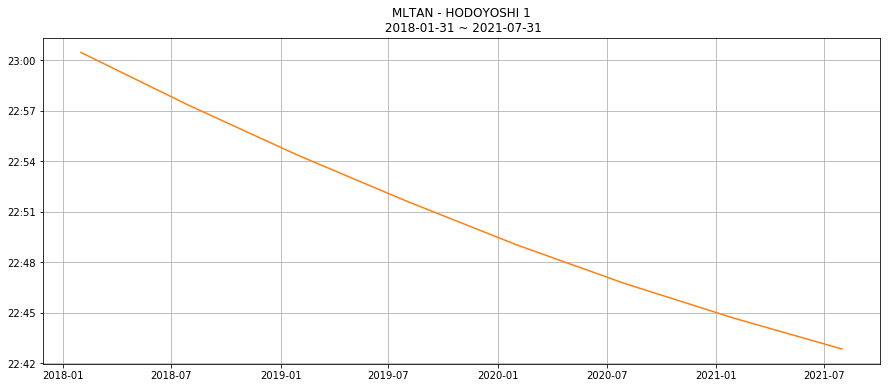

In [9]:
import matplotlib.ticker as tick

fig, ax = plt.subplots(1, figsize=(15,6))
ax.plot(df_ltan_stats['mean'], 'C1')

ax.set_title("MLTAN - {}\n {:%Y-%m-%d} ~ {:%Y-%m-%d}".format(satellite.name, df_ltan_stats.index[0], df_ltan_stats.index[-1]))
frm = tick.FuncFormatter(lambda x, y: '{:02d}:{:02d}'.format(int(np.floor(x)), int((x % 1) * 60)))
ax.yaxis.set_major_formatter(frm)

plt.grid();
plt.show();

## Sources

- http://www.celestrak.com/NORAD/elements/
- https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/20150010230.pdf
- http://cires1.colorado.edu/events/lidarworkshop/LWG/Jun09/Papers.jun09/Kavaya2.jun09.pdf
- https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/20080012667.pdf
- http://rhodesmill.org/skyfield/positions.html#barycentric-position
- http://issfd.org/2015/files/downloads/papers/107_Mazzoleni.pdf
- https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/20080012667.pdf
- https://arc.aiaa.org/doi/abs/10.2514/6.2015-4488
- https://space.stackexchange.com/questions/22125/how-local-time-of-a-sun-synchronous-orbit-is-related-to-right-ascension-of-ascen
- https://www.yumpu.com/en/document/view/36384921/mean-local-time-of-the-ascending-node-orbital-and-celestial-
- MLTAN of existing satellites
    - https://earthi.space/wp-content/uploads/2018/03/Earth-i-Tech-Spec-for-KOMPSAT.pdf
    - https://satellitesafety.gsfc.nasa.gov/missions.html
    - http://www.remss.com/support/crossing-times/